In [137]:
import numpy as np
import os
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes
import scipy.interpolate as spi
import matplotlib.pyplot as plt
from textwrap import wrap
import scipy.linalg as spl
import networkx as nx

In [133]:
def GeneralizedProcrustesAnalysis(Shapes:list, error = 1e-1, maxIter = 10) -> list:
    # Shapes is a list of k shapes made of (L, 2) L 2D landmarks
    refShape = Shapes[0] # Arbitrary selected
    k = len(Shapes)
    newShapes = Shapes

    iter = 0
    print(f'Running generalized procruste analysis on the data.')
    while iter < maxIter:
        # Is it ok to reassign refShape every time?    
        meanShape = refShape
        for i in range(1, k):
            refShape, alignedShape, disparity = procrustes(refShape, newShapes[i])
            newShapes[i] = alignedShape
            meanShape += alignedShape 
        meanShape /= k 
        
        dist = np.linalg.norm(meanShape-refShape)
        print(f'\tDistance between mean shape and reference shape {dist=}.')
        iter+=1
        if dist < error:
            print('\tError reached tolerance, terminating GPA.')
            print(f'\tTolerance achieved in {iter} iterations. Stopping the alignement procedure.')
            break
    refShape = meanShape
    return newShapes, meanShape.reshape((-1,))

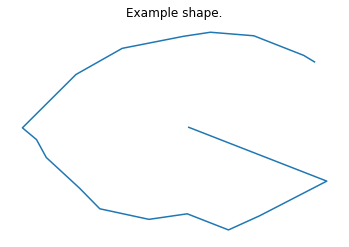

In [134]:
segmentationList = []
dataDir = '/home/remi/Statistical Shape Model/Data'
for file in os.listdir(dataDir):
    data = np.loadtxt(dataDir+'/'+file, delimiter=',', skiprows=1)[:,1:]
    data = data[[16,15,14,13,12,11,10,9,0,1,2,3,4,5,6,7,8,-1],:]
    segmentationList.append(data)
plt.plot(data[:,0], data[:,1])
plt.title('Example shape.')
plt.axis('off')
plt.show()

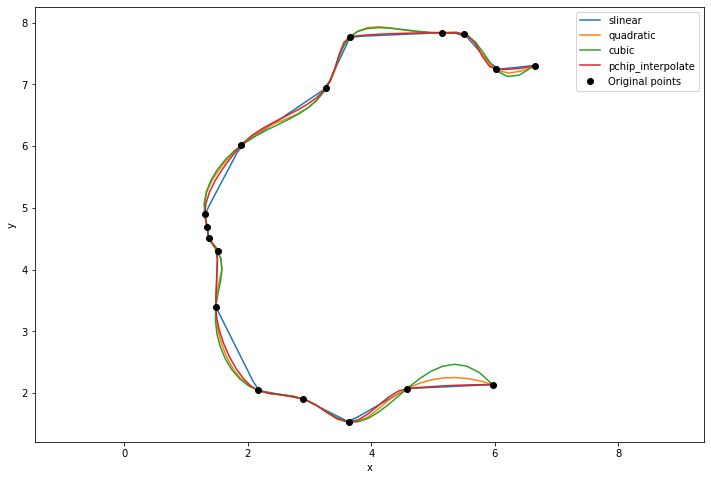

In [14]:
interpolations_methods = ['slinear', 'quadratic', 'cubic']

fig = plt.figure(figsize=(12,8))

interp1d = spi.interp1d


points = segmentationList[0][:-1] # A test shape without the fovea
distance = np.cumsum(np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1))) # Compute the arc length of the curve's points, i.e., the curve is assumed to be parametrized by (x,y) = f(s) 
distance = np.insert(distance, 0,0)/distance[-1] # Normalize the arc length

alpha = np.linspace(0, 1, 75)
interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:

for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name);

curve = spi.pchip_interpolate(distance, points, alpha, axis=0)
plt.plot(*curve.T, '-', label='pchip_interpolate')
plt.plot(*points.T, 'ok', label='Original points');
plt.axis('equal'); 
plt.legend(); plt.xlabel('x'); plt.ylabel('y');

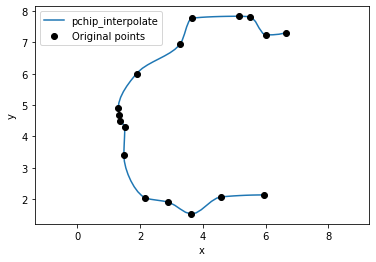

In [15]:
fig = plt.figure()
curve = spi.pchip_interpolate(distance, points, alpha, axis=0)
plt.plot(*curve.T, '-', label='pchip_interpolate')
plt.plot(*points.T, 'ok', label='Original points')
plt.axis('equal'); 
plt.legend(); plt.xlabel('x'); plt.ylabel('y');

### Test: Interpolating before Procrustes analysis

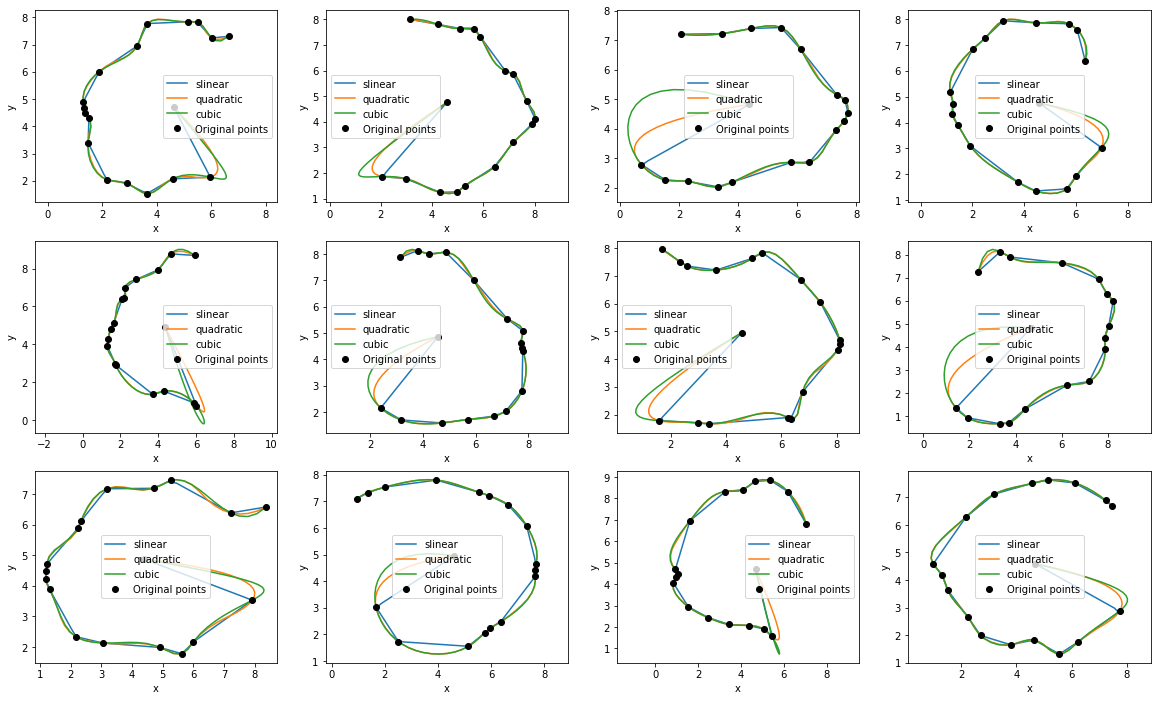

In [16]:
n = 12 # Make it a multiple of 4
interpolations_methods = ['slinear', 'quadratic', 'cubic']


n = min(len(segmentationList), n)
fig, axes = plt.subplots(n//4,4, figsize=(20,12))
axes = axes.ravel()

interp1d = spi.interp1d

for i, seg in enumerate(segmentationList):
    points = seg#[:-1] # A test shape without the fovea
    distance = np.cumsum(np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1))) # Compute the arc length of the curve's points, i.e., the curve is assumed to be parametrized by (x,y) = f(s) 
    distance = np.insert(distance, 0,0)/distance[-1] # Normalize the arc length

    alpha = np.linspace(0, 1, 75)
    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)

    # Graph:

    for method_name, curve in interpolated_points.items():
        axes[i].plot(*curve.T, '-', label=method_name);
        
    axes[i].plot(*points.T, 'ok', label='Original points');
    axes[i].axis('equal'); 
    axes[i].legend(); axes[i].set_xlabel('x'); axes[i].set_ylabel('y');

### Test: Interpolating after Procrustes

In [17]:
newShapes, meanShape = GeneralizedProcrustesAnalysis(segmentationList, maxIter=5)

Running generalized procruste analysis on the data.
	Distance between mean shape and reference shape dist=2.819647806914679.
	Distance between mean shape and reference shape dist=0.9469488846357884.
	Distance between mean shape and reference shape dist=0.9469488846357885.
	Distance between mean shape and reference shape dist=0.9469488846357884.
	Distance between mean shape and reference shape dist=0.9469488846357883.


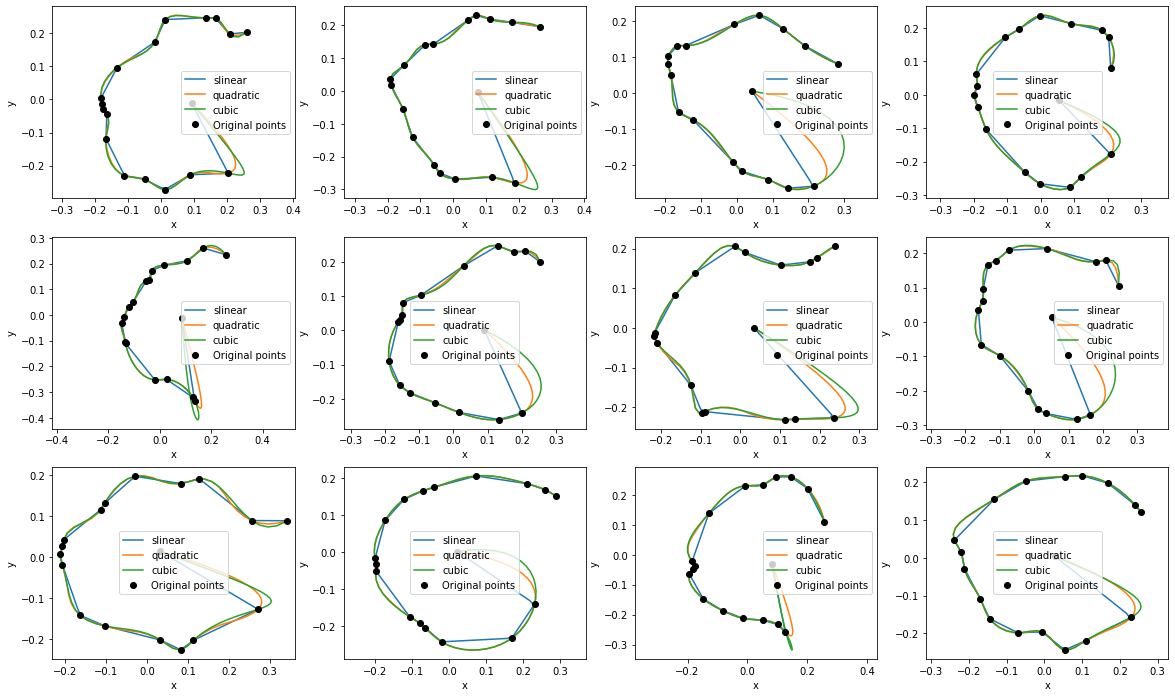

In [18]:
n = 12 # Make it a multiple of 4


n = min(len(newShapes), n)
fig, axes = plt.subplots(n//4,4, figsize=(20,12))
axes = axes.ravel()

interp1d = spi.interp1d

for i, seg in enumerate(newShapes):
    points = seg#[:-1] # A test shape without the fovea
    distance = np.cumsum(np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1))) # Compute the arc length of the curve's points, i.e., the curve is assumed to be parametrized by (x,y) = f(s) 
    distance = np.insert(distance, 0,0)/distance[-1] # Normalize the arc length

    alpha = np.linspace(0, 1, 75)
    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)

    # Graph:

    for method_name, curve in interpolated_points.items():
        axes[i].plot(*curve.T, '-', label=method_name);
        
    axes[i].plot(*points.T, 'ok', label='Original points');
    axes[i].axis('equal'); 
    axes[i].legend(); axes[i].set_xlabel('x'); axes[i].set_ylabel('y');

# Orthogonal Procrustes Analysis (only orthogonal transformations, i.e., reflections and rotations)

In [19]:
def GeneralizedOrthogonalProcrustes(Shapes:list, error = 1e-1, maxIter = 10) -> list:
    # Shapes is a list of k shapes made of (L, 2) L 2D landmarks
    centeredShapes = []
    for shape in Shapes:
        fovea = shape[-1]
        centeredShapes.append(shape[:-1]-fovea)

    refShape = centeredShapes[0] # Arbitrary selected
    k = len(centeredShapes)
    newShapes = centeredShapes

    iter = 0
    print(f'Running generalized procruste analysis on the data.')
    while iter < maxIter:
        # Is it ok to reassign refShape every time?    
        dist = 0
        meanShape = refShape
        for i in range(1, k):
            R, sca = orthogonal_procrustes(newShapes[i], refShape)
            # refShape, alignedShape, disparity = procrustes(refShape, newShapes[i])
            newShapes[i] = newShapes[i].dot(R)
            meanShape += newShapes[i]
            dist += np.linalg.norm(refShape-newShapes[i])
        meanShape /= k 
        

        print(f'\tDistance between mean shape and reference shape {dist=}.')
        iter+=1
        if dist < error:
            print('\tError reached tolerance, terminating GPA.')
            print(f'\tTolerance achieved in {iter} iterations. Stopping the alignement procedure.')
            break
    newShapes[0] = refShape
    return newShapes

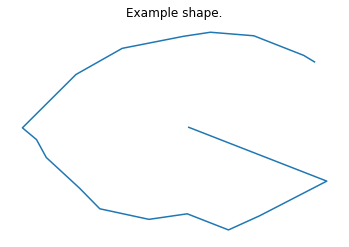

In [20]:
segmentationList = []
dataDir = '/home/remi/Statistical Shape Model/Data'
for file in os.listdir(dataDir):
    data = np.loadtxt(dataDir+'/'+file, delimiter=',', skiprows=1)[:,1:]
    data = data[[16,15,14,13,12,11,10,9,0,1,2,3,4,5,6,7,8,-1],:]
    segmentationList.append(data)
plt.plot(data[:,0], data[:,1])
plt.title('Example shape.')
plt.axis('off')
plt.show()

In [21]:
newShapesOrthogonalProcrustes = GeneralizedOrthogonalProcrustes(segmentationList)

Running generalized procruste analysis on the data.
	Distance between mean shape and reference shape dist=870.1054643594101.
	Distance between mean shape and reference shape dist=874.9765051916835.
	Distance between mean shape and reference shape dist=875.454660567479.
	Distance between mean shape and reference shape dist=875.4950008897216.
	Distance between mean shape and reference shape dist=875.4983658645449.
	Distance between mean shape and reference shape dist=875.4986462881782.
	Distance between mean shape and reference shape dist=875.4986696557204.
	Distance between mean shape and reference shape dist=875.4986716029116.
	Distance between mean shape and reference shape dist=875.4986717651685.
	Distance between mean shape and reference shape dist=875.4986717786892.


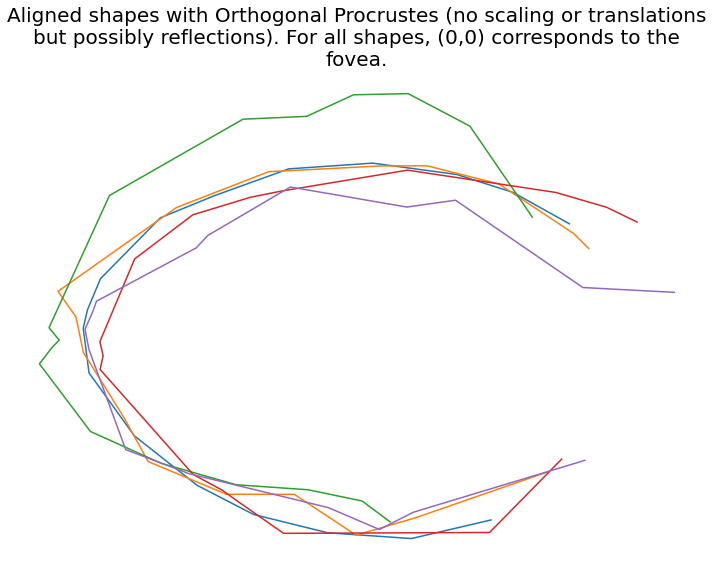

In [50]:
fig,ax = plt.subplots(1,1, figsize=(10,8))
ax.set_axis_off()
for i in range(5):
     ax.plot(newShapesOrthogonalProcrustes[-i][:,0], newShapesOrthogonalProcrustes[-i][:,1])
ax.set_title("\n".join(wrap("Aligned shapes with Orthogonal Procrustes (no scaling or translations but possibly reflections). For all shapes, (0,0) corresponds to the fovea.")), fontsize=20)
fig.tight_layout()
plt.show()

In [23]:
from scipy.spatial.transform import Rotation as rotation

def Kabsch(Shapes:list, error = 1e-1, maxIter = 1) -> list:
    # Shapes is a list of k shapes made of (L, 2) L 2D landmarks
    centeredShapes = []
    for shape in Shapes:
        fovea = shape[-1]
        centeredShapes.append(shape[:-1]-fovea)

    centeredShapes = centeredShapes
    k = len(centeredShapes)
    newShapes = np.array(centeredShapes)
    newShapes = np.pad(newShapes, ((0,0), (0,0), (0,1)))
    refShape = newShapes[0] # Arbitrary selected


    iter = 0
    print(f'Running generalized procruste analysis on the data.')
    while iter < maxIter:
        # Is it ok to reassign refShape every time?    
        dist = 0
        for i in range(1, k):
            R, rssd = rotation.align_vectors(refShape, newShapes[i])
            dist += rssd
            newShapes[i] = R.apply(newShapes[i])
        

        print(f'\tDistance between mean shape and reference shape {dist=}.')
        iter+=1
        if dist < error:
            print('\tError reached tolerance, terminating GPA.')
            print(f'\tTolerance achieved in {iter} iterations. Stopping the alignement procedure.')
            break
    newShapes[0] = refShape
    return newShapes[...,:-1]

In [24]:
newShapesKabsch = Kabsch(segmentationList)

Running generalized procruste analysis on the data.
	Distance between mean shape and reference shape dist=46.05005050356898.


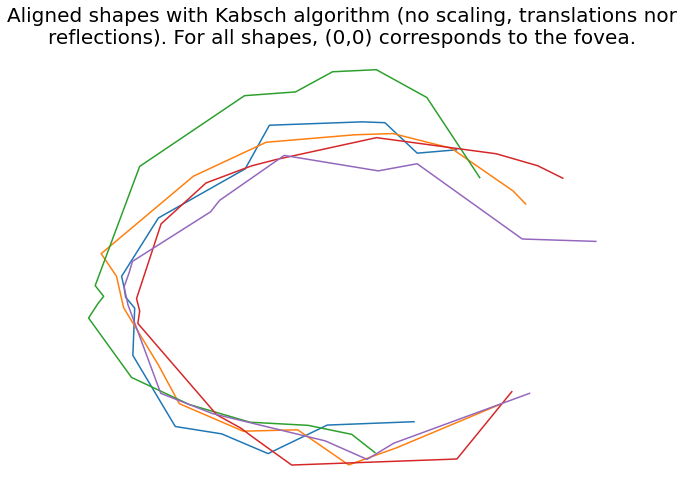

In [51]:
plt.figure(figsize=(10,8))
plt.axis('off')
for i in range(5):
    plt.plot(newShapesKabsch[-i][:,0], newShapesKabsch[-i][:,1])
plt.title("\n".join(wrap("Aligned shapes with Kabsch algorithm (no scaling, translations nor reflections).\nFor all shapes, (0,0) corresponds to the fovea.")), fontsize=20)
plt.show()

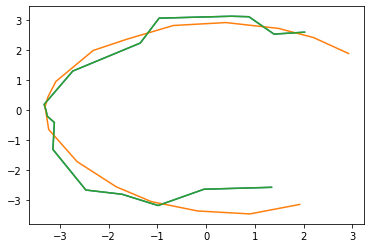

In [56]:
plt.plot(*newShapesKabsch[0].T)
plt.plot(*newShapesOrthogonalProcrustes[0].T)
plt.plot(*(segmentationList[0][:-1,...]-segmentationList[0][-1,...]).T)

Text(0.5, 1.0, 'Original shapes, centered at the fovea.')

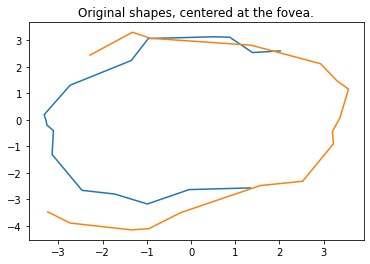

In [91]:
centeredShapes = []
for shape in segmentationList:
    fovea = shape[-1]
    centeredShapes.append(shape[:-1]-fovea)
centeredShapes = np.pad(np.array(centeredShapes), ((0,0), (0,0), (0,1)))
A,B = centeredShapes[0], centeredShapes[7]
plt.plot(*A[...,:-1].T); plt.plot(*B[...,:-1].T);plt.title("Original shapes, centered at the fovea.")

Reflect over the vertical axis if the OD is on opposite sides

Text(0.5, 1.0, 'Original shapes, centered at the fovea.')

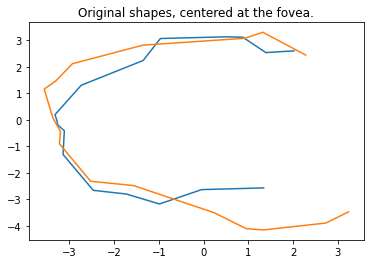

In [95]:
OD_A = np.sign(A[int(A.shape[0]/2),0])
OD_B = np.sign(B[int(B.shape[0]/2),0])
if OD_A!=OD_B:
    B = B.dot(np.array([[-1,0,0], [0,1,0], [0,0,1]]))

plt.plot(*A[...,:-1].T); plt.plot(*B[...,:-1].T);plt.title("Original shapes, centered at the fovea.")

Align shapes

In [97]:
K = A.T.dot(B)
U,s,V = spl.svd(K)
Q = V.dot(U.T)
WithReflection = A.dot(Q)
V[:,-1] *= -1.0
Q = V.dot(U.T)
WithoutReflection = A.dot(Q)

plt.figure(figsize=(12,8))
plt.plot(*B[...,:-1].T, label='Reference shape')
plt.plot(*WithReflection[...,:-1].T, label='Rotated and Reflected'); 
plt.plot(*WithoutReflection[...,:-1].T, label='Rotated only'); 

plt.legend()
plt.title("Rotated shapes, centered at the fovea.")

[[ 0.9178499  -0.39692764  0.        ]
 [ 0.39692764  0.9178499   0.        ]
 [ 0.          0.         -1.        ]]


In [271]:
def AlignShapes(shapes : list | np.ndarray, foveaIndex : int =-1,
                type:str='orthogonal'):
    '''
    Fovea index is the position of the fovea's coordinates in the 
    list of landmarks. By default, it is the last one.
    Reflect over the horizontal axis if necessary. This assumes
    that the location of the optic disc is at the middle of 
    the set of points.  
    '''
    # Make the fovea the origin for each shapes
    centeredShapes = []
    for shape in segmentationList:
        fovea = shape[foveaIndex]
        centeredShapes.append(np.delete(shape,foveaIndex,0)-fovea) # remove the fovea from the list of points
    centeredShapes = np.array(centeredShapes)
    L,n = centeredShapes[0].shape

    # Define a randomly selected reference shape
    ref = 0 #np.random.randint(0,centeredShapes.shape[0])
    refShape = centeredShapes[ref]
    
    # Reflect over the vertical axis if needed 
    # to make all shapes conform to the reference shape
    iOD = int(L/2)
    OD  = np.sign(refShape[iOD,0])
    R   = np.array([[-1,0], [0,1]]) # The reflection matrix
    alignedShapes = [refShape]
    for shape in centeredShapes:
        if np.sign(shape[iOD,0])!=OD:
            shape = shape.dot(R)   
        # Align the shapes
        U,s,V = spl.svd(shape.T.dot(refShape))
        if type=='orthogonal':
            Q = U.dot(V.T) # May allow reflections
            if spl.det(Q)<0: 
                print(f"Determinant of rotation matrix is negative. It looks like there is a reflection\n{Q=}.")
            alignedShapes.append(Q.dot(shape.T).T)

    return np.array(alignedShapes)

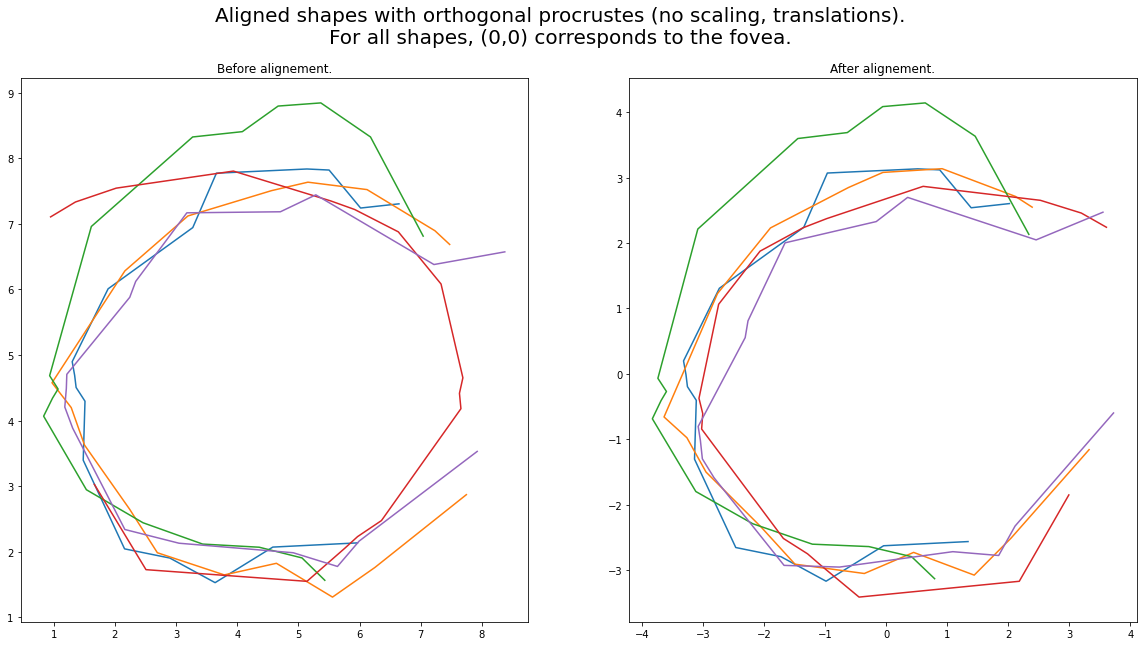

In [272]:
alignedShapes = AlignShapes(segmentationList)

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax = ax.ravel()
#ax[0].set_axis_off(); ax[1].set_axis_off()
for i in range(5):
    ax[0].plot(*segmentationList[-i][:-1].T)
    ax[1].plot(*alignedShapes[-i].T)
ax[0].set_title("Before alignement."); ax[1].set_title("After alignement.")
plt.suptitle("\n".join(wrap("Aligned shapes with orthogonal procrustes (no scaling, translations).\nFor all shapes, (0,0) corresponds to the fovea.")), fontsize=20)
plt.show()

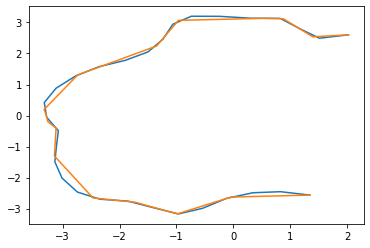

In [302]:
distance = np.cumsum(np.sqrt(np.sum( np.diff(alignedShapes[0], axis=0)**2, axis=1))) # Compute the arc length of the curve's points, i.e., the curve is assumed to be parametrized by (x,y) = f(s) 
distance = np.insert(distance, 0,0)/distance[-1] # Normalize the arc length
sOD = distance[8] # Arc length to the optic disc
interpolator =  interp1d(distance, alignedShapes[0], kind='quadratic', axis=0)
points = interpolator((np.sort(np.insert(np.linspace(0,1,30,endpoint=True), 0, sOD))))
plt.plot(*points.T)
plt.plot(*alignedShapes[0].T)
plt.show()

In [400]:
def ToGraph(shape : list | np.ndarray, indexOD : int, span : float=2.0, radiusCRA : float = 7e-3, nLandmarks : tuple=(None, None), **kwargs):
    """
    Write the vessel landmarks in shape as a new CCO file. 
    Assumes the first point in the list is the CR vessel's location while the remaining points are the superior and inferior temporal vessel.
    Both superior and inferior vessels are assumed to be composed of the same number of landmarks by default.
    If not, specify those numbers in landmarks.

    Argument:
        shape : list or np.ndarray
            the list of 2D points (image landmarks)
        CCOFileName : str
            the output file name
        nLandmarks : tuple
            the number of landmark for each vessel in the shape
        span : float
            the axial length of the vessels (in cm)
    """

    scale = span/(shape.max() - shape.min()).max()
    
    OD = np.pad(shape[indexOD], (0,1))*scale
    #OD[1] = 0.0
    firstVessel = np.pad(shape[indexOD+1:], ((0,0),(0,1)))*scale
    secondVessel = np.pad(np.flip(shape[:indexOD], axis=0), ((0,0),(0,1)))*scale
    # Create the central retinal vessel (out of the plane) to link both vessel to a single inlet
    G = nx.DiGraph()
    G.add_node(0, position=np.array([OD[0], OD[1], -0.1])) # The inlet node
    G.add_node(1, position=OD)
    G.add_edge(0, 1, radius = radiusCRA, key = 0)

    # Add the arcades    
    nodeKey = 2 # Available node key for G
    vesselKey = 1 # Available vessel key for G
    for vessel in (firstVessel, secondVessel):
        nProx = 1 # The key of the distal node of the CRVessel
        for x in vessel:
            x = np.pad(x, (0,1)) # Position of the distal node
            G.add_node(nodeKey, position=x) 
            G.add_edge(nProx, nodeKey, radius = radiusCRA/2.0, key = vesselKey) # All vessel segments have the same width
            nProx = nodeKey
            nodeKey +=1
            vesselKey +=1
    return G
    
def GraphToCCO(CCOFileName : str, G : nx.DiGraph, **kwargs):
    
    # Various tree info in the header of the CCO file
    qProx = kwargs.get('qProx', 2.5000000000000001e-04) # 15 microliter/min in cm3/s, probably
    psiFactor = kwargs.get('psiFactor', 9.6040000000001100e-06) # Not sure what that does
    dp = kwargs.get('dp', 9.5453193691098149e+03) # Pressure drop from the single inlet to all outlet vessels, in Pa
    refPressure = kwargs.get('refPressure', 6.6661199999999999e+03) # Occular perfusion pressure, 50mmHg in Pa
    nTerms = 2

    radiusCRA = G[0][1]['radius']

    with open(CCOFileName, 'w') as f:
        f.write('*Tree\n')
        x = G.nodes[0]['position']
        f.write(f"{x[0]} {x[1]} {x[2]} {qProx} {psiFactor} {dp} {nTerms} {refPressure} {G.number_of_nodes()} {radiusCRA} {1e-6}\n")

        f.write('\n*Vessels\n')
        f.write(f"{G.number_of_edges()}\n")
        for n1, n2, data in G.edges(data=True):
            xProx, xDist = G.nodes[n1]['position'], G.nodes[n2]['position']
            branchingMode = 2 if data['key']==0 else 2 # If the root, then bifurcates at distal end only, else deformable parent
            vesselFunction = 0 # Distribution vessel, bifurcates in the domain only
            f.write(f"{data['key']} {xProx[0]} {xProx[1]} {xProx[2]} {xDist[0]} {xDist[1]} {xDist[2]}")
            f.write(f"0.0 0.0 0.0 0.0 {branchingMode} {data['radius']} {qProx} 0.0 0.0 0.0 {vesselFunction} 0.0 0.0 -1\n")

        f.write('\n*Connectivity')
        for n1, n2, data in G.edges(data=True):
            f.write('\n')

            # Sanity check
            parent = G.predecessors(n1)
            assert sum(1 for _ in parent) <= 1, f'Oops... Something went wrong, more than 1 parent was found {parent=}.'
            descendents = G.successors(n2) 
            assert sum(1 for _ in descendents) <= 2, f'Oops... Something went wrong, more than 2 descendents were found {descendents=}.' 
            # End sanity check 

            parent = G.predecessors(n1)
            descendents = G.successors(n2) 
            try: 
                parentKey = next(parent)
            except:
                parentKey = -1
            f.write(f"{data['key']} {parentKey}")                    
            
            for descendent in descendents:
                f.write(f" {G[n2][descendent]['key']}")



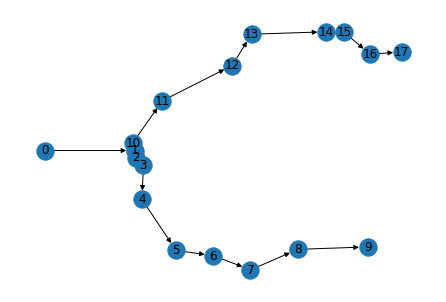

In [401]:
G = ToGraph(alignedShapes[0], 8, span=1.80)
position = {n:(pos[0]+pos[2]*5, pos[1]) for n,pos in G.nodes.data('position')}
nx.draw(G, pos=position, with_labels=True)
GraphToCCO('/home/remi/Virtual-Angiogenesis/WholeRetina/src/SegmentedArcades.cco', G)

In [402]:
n = 15 # Number of training points
m = []
print("Approximation error of optic disc by \Gamma(0.5)")
for shape in alignedShapes:
    OD = shape[8,:] # The OD location

    distance = np.cumsum(np.sqrt(np.sum( np.diff(shape, axis=0)**2, axis=1))) # Compute the arc length of the curve's points, i.e., the curve is assumed to be parametrized by (x,y) = f(s) 
    distance = np.insert(distance, 0,0)/distance[-1] # Normalize the arc length
    interpolator =  interp1d(distance, shape, kind='quadratic', axis=0)
    points = interpolator(np.linspace(0,1,n, endpoint=True))
    points = np.insert(points, 0, OD, axis=0) # Loc of optic disc
    m.append(points)

    print((OD-interpolator(0.5))/shape.max(axis=0))

Approximation error of optic disc by \Gamma(0.5)
[ 0.01876811 -0.06180469]
[ 0.01876811 -0.06180469]
[-0.0455184   0.03974001]
[-0.03785376  0.01894124]
[-0.0025468   0.01187536]
[0.00711939 0.0422729 ]
[0.00478737 0.1292512 ]
[-0.00217201 -0.00879823]
[ 0.00417027 -0.00867896]
[ 0.00207607 -0.01867163]
[ 0.00443089 -0.0244219 ]
[-0.00778072 -0.41815624]
[ 0.01049537 -0.01149894]


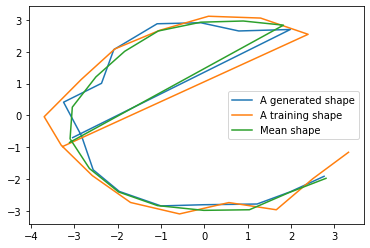

In [403]:
m = np.array(m)
k,_,_ = m.shape
xbar = np.mean(m, axis=0)
#plt.scatter(*xbar.T)
Cov = np.cov(m.reshape((2*(n+1),k)))
eigva, eigve = np.linalg.eig(Cov)
P = np.real(eigve).T
stds = np.sqrt(np.abs(eigva))
newShape = xbar + (P.dot(np.random.normal(0.0, 0.1*stds))).reshape((n+1,2))
plt.plot(*newShape.T, label='A generated shape')
plt.plot(*points.T, label='A training shape')
plt.plot(*xbar.T, label='Mean shape')
plt.legend()
plt.show()

In [404]:
for i, shape in enumerate(alignedShapes):
    G = ToGraph(shape, 8, span=1.80)
    GraphToCCO(f'/home/remi/Virtual-Angiogenesis/WholeRetina/src/base_trees/SegmentedArcades_{i}.cco', G)